In [1]:
from shallowprofiler import ReadProfileMetadata, sensors, ranges, standard_deviations, colors, sensor_names, DataFnm
from charts import ChartTwoSensors
from anomaly import *

# profiles is a pandas DataFrame treated as a global resource 
profiles = ReadProfileMetadata('../profiles/osb_profiles_jan22.csv')


Jupyter Notebook running Python 3


In [2]:
d = {}

for sensor in sensors:
    if not sensor[0] == 'spkir':
        d[sensor[0]] = (xr.open_dataset(DataFnm('osb', sensor[1], 'jan22', sensor[0]))[sensor[0]],
                        xr.open_dataset(DataFnm('osb', sensor[1], 'jan22', sensor[0]))['z'],
                        ranges[sensor[0]][0], ranges[sensor[0]][1], colors[sensor[0]])
    else:
        waves = ['412nm', '443nm','490nm','510nm','555nm','620nm','683nm']
        for wave in waves:
            d[wave] = (xr.open_dataset(DataFnm('osb', 'spkir', 'jan22', 'spkir'))[wave],
                       xr.open_dataset(DataFnm('osb', 'spkir', 'jan22', 'spkir'))['z'],
                       ranges['spkir'][0], ranges['spkir'][1], colors['spkir'])

In [3]:
# So now we have d['density'] and so forth: So print the keys of this dictionary
for da in d: print(da)

sensors_phase1 = ['conductivity', 'density', 'salinity', 'temperature', 'do', 'chlora', 'bb', 'fdom']
sensors_phase2 = ['nitrate', 'pco2', 'ph']
sensors_phase3 = ['par', '412nm', '443nm', '490nm', '510nm', '555nm', '620nm', '683nm']
sensors_phase4 = ['oa', 'ba']
# vel is handled independently

conductivity
density
pressure
salinity
temperature
chlora
bb
fdom
412nm
443nm
490nm
510nm
555nm
620nm
683nm
nitrate
pco2
do
par
ph
up
east
north


In [4]:
# a reminder of the 5-tuple dictionary d
print(d['temperature'][0].name)
print(d['temperature'][1].name)
print(d['temperature'][2])
print(d['temperature'][3])
print(d['temperature'][4])

print(type(d['temperature'][1]))

temperature
z
7
12
red
<class 'xarray.core.dataarray.DataArray'>


In [5]:
# Move to charts.py: A composite chart from sensor mean and std dev

# flag bug no markers are displayed

def ChartMeanStdDev(name, ranges, daM, daSD, wid, hgt, colorM, colorSD):
    fig, ax = plt.subplots(figsize=(wid, hgt), tight_layout=True)
    axtwin = ax.twiny()
    sdcol = 'magenta'
    ax.plot(    daM,         daM['z'],  ms =   4., color=colorM,  mfc=colorM)
    ax.plot(    daM + daSD,  daM['z'],  ms =  10., color=sdcol,  mfc='red')
    ax.plot(    daM - daSD,  daM['z'],  ms =  10., color=sdcol,  mfc='red')
    axtwin.plot(daSD,        daSD['z'], ms =   4., color=colorSD, mfc=colorSD)
    z0, z1 = -200., 0.
    ax.set(    xlim = (ranges[0][0], ranges[0][1]), ylim = (z0, z1))
    axtwin.set(xlim = (ranges[1][0], ranges[1][1]), ylim = (z0, z1))
    ax.set(title=name + ': Mean, StdDev')
    return

### Development code for understanding a sensors profile with depth


Note the placeholder remark on a low-pass filter.


```
# Using depth bins ('z') compute means and standard deviations
n_meters          = 200
n_meters_per_bin  = 2
bin_upper_zs      = np.linspace(-n_meters, 0,1 + int(n_meters/n_meters_per_bin))                 
bin_upper_zs

sensor_name = 'temperature'
dd   = d[sensor_name]                    # tuple (DataArray, DataArray, range0, range1, color
print(dd[0].name)
print(dd[1].name)
print(dd[2])
print(dd[3])
print(dd[4])
ds   = xr.merge([dd[0], dd[1]])            # accepts a list of DataArrays
ds   = ds.swap_dims({'time':'z'})
ds   = ds.drop('time')

dsM  = ds.groupby_bins('z', bin_upper_zs).mean()
dsSD = ds.groupby_bins('z', bin_upper_zs).std()
dsC  = ds.groupby_bins('z', bin_upper_zs).count()

dsM=dsM.assign_coords(z_bins=np.array([v.mid for v in dsM.z_bins.values])).rename({'z_bins': 'z'})
dsSD=dsSD.assign_coords(z_bins=np.array([v.mid for v in dsSD.z_bins.values])).rename({'z_bins': 'z'})
dsC=dsC.assign_coords(z_bins=np.array([v.mid for v in dsC.z_bins.values])).rename({'z_bins': 'z'})
dsM['z'][0:30]

# flag a low pass filter would go here

ChartMeanStdDev(sensor_name, [ranges[sensor_name],standard_deviations[sensor_name]], dsM[sensor_name], dsSD['stddev'], 10, 8, dd[4], 'black')
```

#### Example of seaborn for relative magnitude charting

```
import seaborn as sns

x = np.array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
y = np.array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4])
z = np.array([249, 523, 603, 775, 577, 763, 808, 695, 642, 525, 795, 758])
df = pd.DataFrame({'x':x, 'y':y, 'z':z})

sns.relplot(data=df, x='x', y='y', size='z', sizes=(10, 100), hue='z', palette='coolwarm',)
```

#### Compile a dictionary of reference profiles (mean, stddev, count)

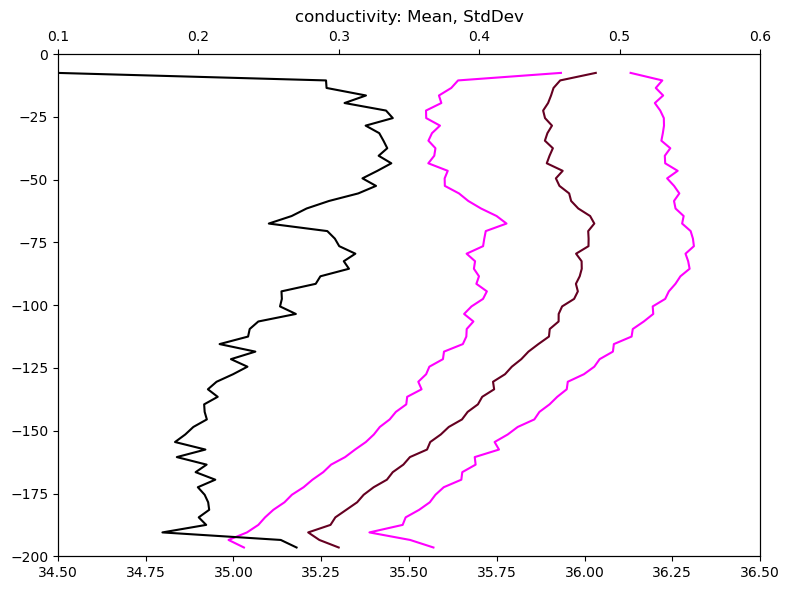

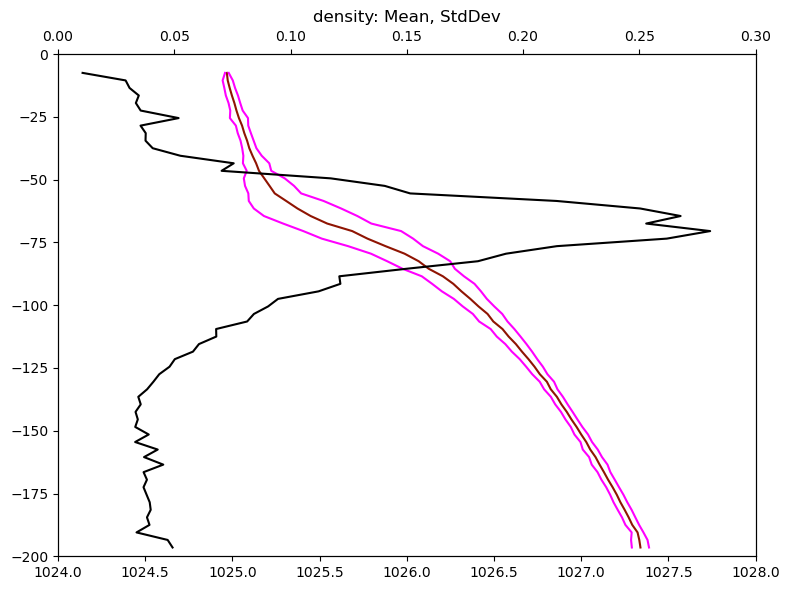

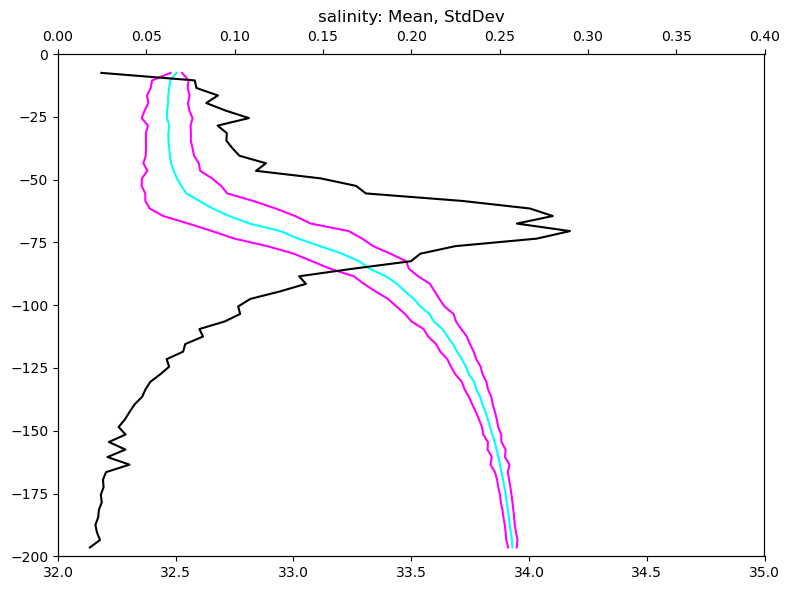

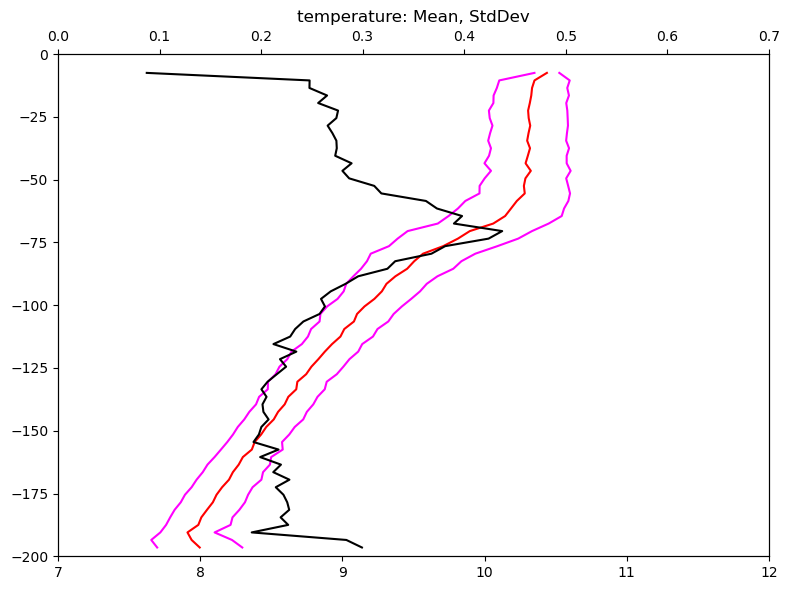

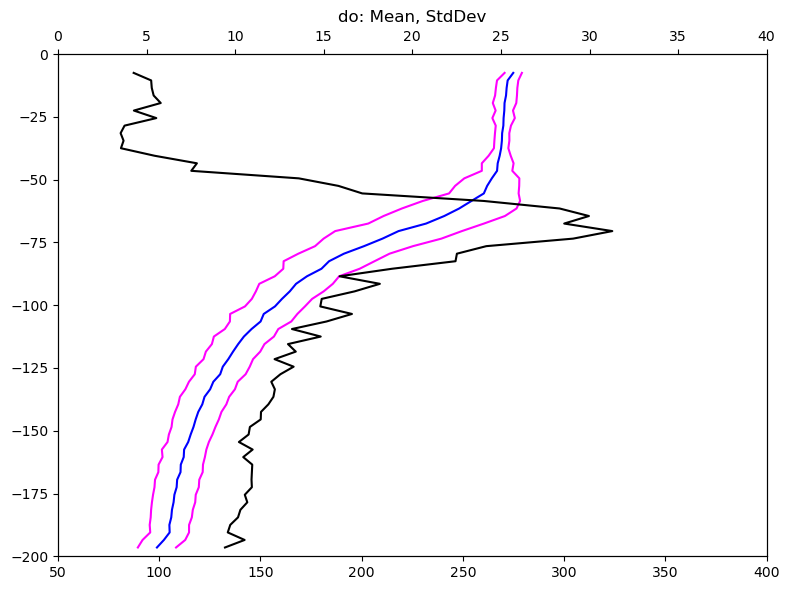

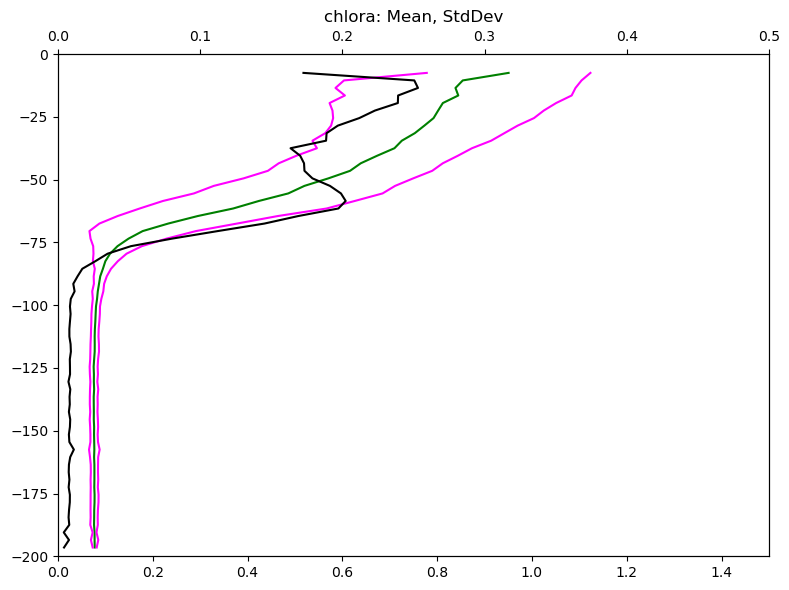

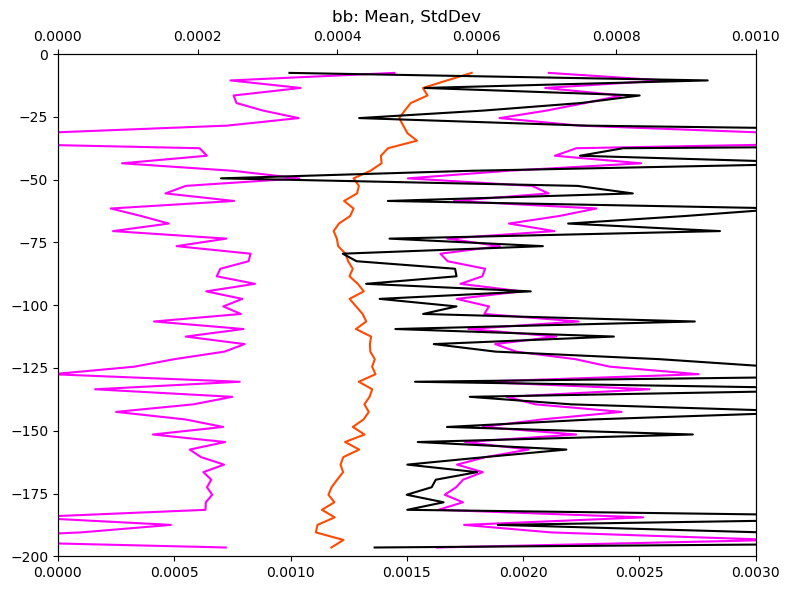

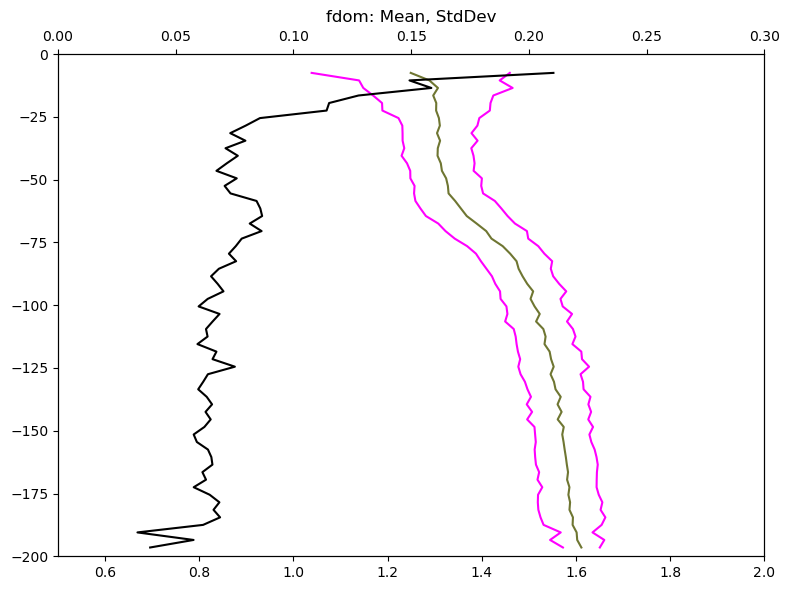

In [6]:
# r1 will be the phase-1 *r*eference dictionary
#  tuple of 3 data arrays: mean, stddev, count (all three include depth dimension/coord z)
#  the upper depth is zero
#  the lower depth is <= -200 and is chosen to give an integer bin count

n_zone_meters     = 201
n_meters_per_bin  = 3
bin_upper_zs      = np.linspace(-n_zone_meters + n_meters_per_bin, 0, n_zone_meters//n_meters_per_bin)         

r1 = {}                                      # r1 will be a dictionary of triples ( , , )
for sensor_name in sensors_phase1:
    dd   = d[sensor_name]                    # 5-tuple (DataArray, DataArray, range0, range1, color
    ds   = xr.merge([dd[0], dd[1]])
    ds   = ds.swap_dims({'time':'z'})
    ds   = ds.drop('time')
    dsM  = ds.groupby_bins('z', bin_upper_zs).mean()
    dsM  = dsM.assign_coords(z_bins=np.array([v.mid for v in dsM.z_bins.values])).rename({'z_bins': 'z'})
    dsSD = ds.groupby_bins('z', bin_upper_zs).std()
    dsSD = dsSD.assign_coords(z_bins=np.array([v.mid for v in dsSD.z_bins.values])).rename({'z_bins': 'z'}).rename({sensor_name: 'stddev'})
    dsC  = ds.groupby_bins('z', bin_upper_zs).count()
    dsC  = dsC.assign_coords(z_bins=np.array([v.mid for v in dsC.z_bins.values])).rename({'z_bins': 'z'}).rename({sensor_name: 'count'})
    r1[sensor_name] = (dsM[sensor_name], dsSD['stddev'], dsC['count'])
    ChartMeanStdDev(sensor_name, [ranges[sensor_name], standard_deviations[sensor_name]], dsM[sensor_name], dsSD['stddev'], 8, 6, dd[4], 'black')

In [7]:
#### Verify reference generation agrees with a traditional means of calculation

[(-205.0, 0.0),
 (7.0, 12.0),
 Text(0.5, 1.0, 'Compare XArray and Philistine temperature means')]

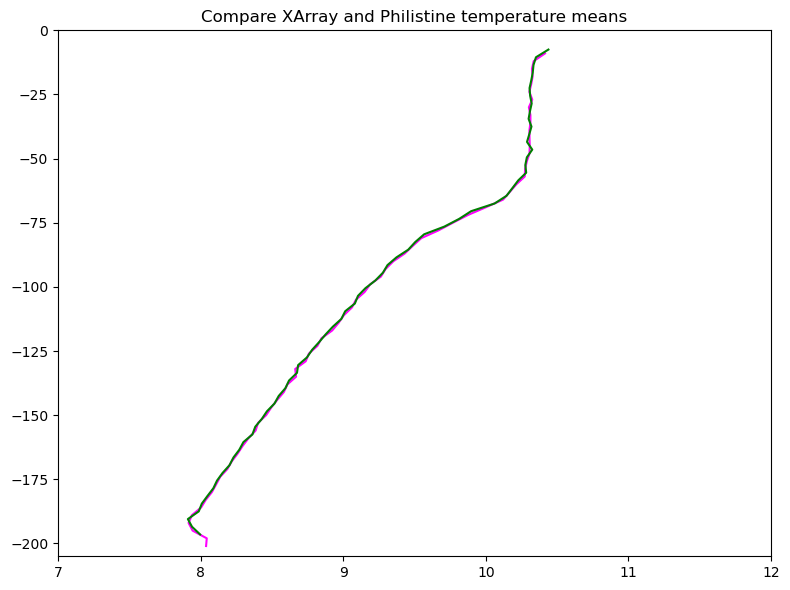

In [8]:
# let's do temperature old school and make sure it looks the same
tt=d['temperature'][0].data
tz=d['temperature'][1].data
# ndarrays: print(type(tt), type(tz)); tt.shape gives (44638,)

tdata = list(tt)            # list of a month of values, 1Min
zdata = list(tz)
ndata = len(tdata)
z     = np.arange(-201, 0, 3)
nbins = len(z)              # 67 3-meter bins cover 0 -- -201

tmean_list, zhistogram_list = [0.]*nbins, [0.]*nbins

for i in range(ndata):
    this_depth_bin = int((tz[i]+201)/3)
    if this_depth_bin < 0: this_depth_bin = 0
    tmean_list[this_depth_bin] += tdata[i]
    zhistogram_list[this_depth_bin] += 1.

for i in range(nbins):
    if zhistogram_list[i] == 0: tmean_list[i] = float('nan')
    else:                       tmean_list[i] = tmean_list[i]/zhistogram_list[i]
        
fig,ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.plot(    tmean_list, z,  ms =   4., color='magenta')
ax.plot(r1['temperature'][0], r1['temperature'][0]['z'], color='green')
ax.set(ylim = (-205, 0), xlim = (7, 12), title='Compare XArray and Philistine temperature means')

```
# flag bug fix this for k in r1: print(k[0].name)
```

### on to anomalies


Now we have r1 which is reference for phase 1. Let's generate both ascent and descent anomaly maps. Start with ascent.


r1 is a dictionary of 7 3-tuples keyed by an r1 sensor name from { conductivity, density, salinity, temperature, o2, chlora, bb, fdom }.


The 3-tuple is three DataArrays: (sensor, stddev, count)



In [9]:
n_profiles = len(profiles)
n_zbins    = n_zone_meters//n_meters_per_bin
anomalies  = {}
for sensor_name in sensors_phase1:
    
    a = np.zeros((n_zbins, n_profiles))     # bins are {-201 - -198, -198 - -195, ..., -3 - 0} qty 67
                                            #   So [-201, 198) -> 0, [-198, 195) -> 1... so rhs of bin 0 maps to integer 1
    for i in range(n_profiles):
        daData   = d[sensor_name][0].sel(time=slice(profiles["a0t"][i], profiles["a1t"][i]))
        daZ      = d[sensor_name][1].sel(time=slice(profiles["a0t"][i], profiles["a1t"][i]))
        zi_list  = [int((z + 201.)/3) for z in daZ]          # zi_list is: For each profile element, the index of its z depth
        
        # list comprehension:
        #   j ranges across all of the indices for this particular profile (so it is in effect a time index by minutes)
        #   The calculated value for this j is (reference - data) / stddev where
        #       reference is the mean data value at this depth (indexed by zi_list[j])
        #       stddev is just that (indexed in the same manner)
        #       Note that data is referenced directly by the j index
        
        err_list = [(r1[sensor_name][0][zi_list[j]]-daData[j])/r1[sensor_name][1][zi_list[j]].data for j in range(len(zi_list))]
        for j in range(len(err_list)): a[zi_list[j], i] = err_list[j]
    anomalies[sensor_name] = a
    print('added ' + sensor_name + ' to anomaly dictionary')
    
    # the 100 depth cuts are -198, -196, ..., 0 so index by depth z is int((z + 198.)/2): 0, 1, ..., 99
    # ref value is r1['sensor_name'][0][j]
    # ref sd    is r1['sensor_name'][1][j]

added conductivity to anomaly dictionary
added density to anomaly dictionary
added salinity to anomaly dictionary
added temperature to anomaly dictionary
added do to anomaly dictionary
added chlora to anomaly dictionary
added bb to anomaly dictionary
added fdom to anomaly dictionary


In [ ]:
for sensor in sensors_phase1:
    print(sensor, np.nanmean(anomalies[sensor]))


In [ ]:
n_phase1 = len(sensors_phase1)

x, y = np.arange(0, 279, 1.), np.arange(-201, 0, 3)
X, Y = np.meshgrid(x, y)
im, ax_divider_list, colorbar_axis_list, colorbar_list = [], [], [], []

fig, axs = plt.subplots(n_phase1, figsize=(16, 6*n_phase1))
fig.subplots_adjust(wspace=0.5)

for i in range(n_phase1):
    sensor_name = sensors_phase1[i]
    axs[i].contourf(X, Y, anomalies[sensor_name], cmap='gist_earth')
    axs[i].set(title=sensor_name)

In [ ]:
fig, axs = plt.subplots(2, figsize=(16, 12))

for i in [0, 1]:    
    im = axs[i].imshow(anomalies[sensors_phase1[i]], cmap='gist_earth')
    fig.colorbar(im, cax=axs[0], orientation='vertical')
    # plt.show()
    
    # just wrong: im.append(axs[i].imshow(anomalies[sensor_name]))
    # ax_divider_list.append(make_axes_locatable(im[i]))
    # cax.append(ax_divider[-1].append_axes("right", size="7%", pad="2%"))
    # cb.append(fig.colorbar(im[-1], cax=cax[-1]))

    
"""
plt.imshow(Bho, origin='l')
plt.contour(Bho, [300,400,500],origin='lower', colors=['white', 'yellow', 'red'])
plt.colorbar()
"""

plt.show()

In [ ]:
# for this_ref in r1:
    # print(this_ref, ' has mean data array with name ' + r1[this_ref][0].name)
    